In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


datetime_trainval.shape:   (92975, 1)
datetime_test.shape    :   (9910, 1)
pvls_trainval.shape    :   (92975, 1)
pvls_test.shape        :   (9910, 1)
images_trainval.shape  :   (92975, 64, 64, 3)
images_test.shape      :   (9910, 64, 64, 3)

len pvls_trainval_sunny      :  58641
len pvls_trainval_cloudy     :  27762
len pvl_trainval_overcast    :  6571
len images_trainval_sunny    :  58641
len images_trainval_cloudy   :  27762
len images_trainval_overcast :  6571

len pvls_test_sunny          :  5925
len pvls_test_cloudy         :  2941
len pvls_test_overcast       :  1043
len images_test_sunny        :  5925
len images_test_cloudy       :  2941
len images_test_overcast     :  1043

sunny training samples: 52776
sunny validati samples: 5865
sunny torch img shape : torch.Size([3, 64, 64])
device: cuda

Training & validation for sunny ...

Epoch 01/10: Train loss: 9.954 | Valid loss: 3.670 | Duration: 0.48 mins
Epoch 02/10: Train loss: 2.953 | Valid loss: 2.162 | Duration: 0.48 mins
Epoc

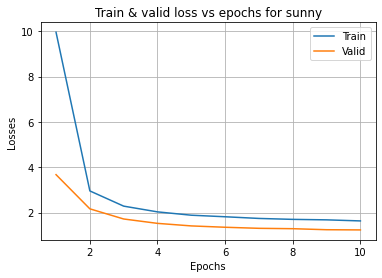

100%|██████████| 5925/5925 [00:08<00:00, 698.06it/s]


Test set rmse: 1.3957765579061487

cloudy training samples: 24985
cloudy validati samples: 2777
cloudy torch img shape : torch.Size([3, 64, 64])
device: cuda

Training & validation for cloudy ...

Epoch 01/10: Train loss: 11.439 | Valid loss: 7.655 | Duration: 0.23 mins
Epoch 02/10: Train loss: 6.858 | Valid loss: 6.093 | Duration: 0.23 mins
Epoch 03/10: Train loss: 5.651 | Valid loss: 5.057 | Duration: 0.23 mins
Epoch 04/10: Train loss: 4.831 | Valid loss: 4.550 | Duration: 0.23 mins
Epoch 05/10: Train loss: 4.396 | Valid loss: 4.179 | Duration: 0.23 mins
Epoch 06/10: Train loss: 4.086 | Valid loss: 3.955 | Duration: 0.23 mins
Epoch 07/10: Train loss: 3.853 | Valid loss: 3.756 | Duration: 0.23 mins
Epoch 08/10: Train loss: 3.666 | Valid loss: 3.620 | Duration: 0.23 mins
Epoch 09/10: Train loss: 3.554 | Valid loss: 3.474 | Duration: 0.23 mins
Epoch 10/10: Train loss: 3.439 | Valid loss: 3.393 | Duration: 0.23 mins

Done!

Total duration: 0.04 hrs


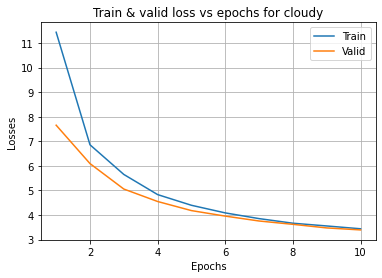

100%|██████████| 2941/2941 [00:04<00:00, 698.88it/s]


Test set rmse: 3.887913516520298

overcast training samples: 5913
overcast validati samples: 658
overcast torch img shape : torch.Size([3, 64, 64])
device: cuda

Training & validation for overcast ...

Epoch 01/10: Train loss: 5.560 | Valid loss: 5.983 | Duration: 0.06 mins
Epoch 02/10: Train loss: 4.296 | Valid loss: 4.925 | Duration: 0.05 mins
Epoch 03/10: Train loss: 3.562 | Valid loss: 3.626 | Duration: 0.05 mins
Epoch 04/10: Train loss: 3.433 | Valid loss: 3.367 | Duration: 0.05 mins
Epoch 05/10: Train loss: 3.315 | Valid loss: 3.186 | Duration: 0.05 mins
Epoch 06/10: Train loss: 3.165 | Valid loss: 3.023 | Duration: 0.05 mins
Epoch 07/10: Train loss: 3.064 | Valid loss: 2.858 | Duration: 0.05 mins
Epoch 08/10: Train loss: 2.947 | Valid loss: 2.798 | Duration: 0.05 mins
Epoch 09/10: Train loss: 2.778 | Valid loss: 2.646 | Duration: 0.05 mins
Epoch 10/10: Train loss: 2.723 | Valid loss: 2.543 | Duration: 0.05 mins

Done!

Total duration: 0.01 hrs


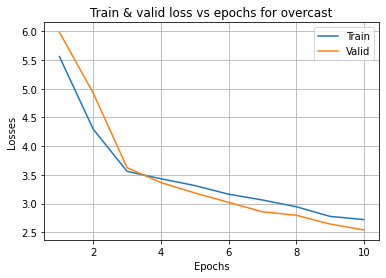

100%|██████████| 1043/1043 [00:01<00:00, 695.94it/s]

Test set rmse: 2.3940283211282436
test_rmse_sunny   : 1.3957765579061487
test_rmse_cloudy  : 3.887913516520298
test_rmse_overcast: 2.3940283211282436

final_test_rmse   : 2.2402927645425716


In [5]:
import gc,time,logging, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import torch
from torch import nn
from torchvision import transforms
from multiprocessing import cpu_count 
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import Sunsets


"""
Formatage du temps
"""
def to_time_min(debut):
    dt = time.time() - debut
    return round(dt / 60, 2)

def to_time_hrs(debut):
    dt = time.time() - debut
    return round(dt / 3600, 2)

#sns.set(style="ticks")

logname = '3classes.log'
handler = logging.FileHandler(logname)
logging.getLogger().addHandler(handler)
logging.getLogger('matplotlib.font_manager').disabled = True
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# datetime data
datetime_trainval= pd.DataFrame(np.load('/content/drive/MyDrive/dataset/datetime_trainval.npy', allow_pickle=True)[()], columns=['d_t'])
print(f"datetime_trainval.shape:   {datetime_trainval.shape}")
datetime_test    = pd.DataFrame(np.load('/content/drive/MyDrive/dataset/datetime_test.npy', allow_pickle=True)[()],columns=['d_t'])
print(f"datetime_test.shape    :   {datetime_test.shape}")

# pv log data
pvls_trainval  = pd.DataFrame(np.load('/content/drive/MyDrive/dataset/pv_log_trainval.npy', allow_pickle=True)[()],columns=['pv_l'])
print(f"pvls_trainval.shape    :   {pvls_trainval.shape}")
pvls_test      = pd.DataFrame(np.load('/content/drive/MyDrive/dataset/pv_log_test.npy', allow_pickle=True)[()],columns=['pv_l'])
print(f"pvls_test.shape        :   {pvls_test.shape}")

# sky images data
images_trainval  = np.load('/content/drive/MyDrive/dataset/images_trainval.npy', allow_pickle=True)[()]
print(f"images_trainval.shape  :   {images_trainval.shape}")
images_test      = np.load('/content/drive/MyDrive/dataset/images_test.npy', allow_pickle=True)[()]
print(f"images_test.shape      :   {images_test.shape}\n")


# Swapping BGR => RGB
# Reference https://stackoverflow.com/questions/4661557/pil-rotate-image-colors-bgr-rgb
images_trainval = images_trainval[:, :, :, ::-1]
images_test     = images_test[:, :, :, ::-1]


# get weather classification

# train
w_class_train_path = '/content/drive/MyDrive/dataset/trainval_phys_3calsses'
w_class_train = pd.read_csv(w_class_train_path)

index_train_sunny = np.where(w_class_train == 'sunny')[0]
index_train_cloudy = np.where(w_class_train == 'cloudy')[0]
index_train_overcast = np.where(w_class_train == 'overcast')[0]

# pvls train
pvls_trainval_sunny = pvls_trainval.loc[index_train_sunny].to_numpy()
print("len pvls_trainval_sunny      : ", len(pvls_trainval_sunny))

pvls_trainval_cloudy = pvls_trainval.loc[index_train_cloudy].to_numpy()
print("len pvls_trainval_cloudy     : ", len(pvls_trainval_cloudy))

pvls_trainval_overcast = pvls_trainval.loc[index_train_overcast].to_numpy()
print("len pvl_trainval_overcast    : ", len(pvls_trainval_overcast))


# img train
images_trainval_sunny = np.array(images_trainval)[index_train_sunny]
print("len images_trainval_sunny    : ", len(images_trainval_sunny))

images_trainval_cloudy = np.array(images_trainval)[index_train_cloudy]
print("len images_trainval_cloudy   : ", len(images_trainval_cloudy))

images_trainval_overcast = np.array(images_trainval)[index_train_overcast]
print("len images_trainval_overcast : ", len(images_trainval_overcast))


# test
w_class_test_path = '/content/drive/MyDrive/dataset/test_phys_3calsses'
w_class_test = pd.read_csv(w_class_test_path)

index_test_sunny = np.where(w_class_test == 'sunny')[0]
index_test_cloudy = np.where(w_class_test == 'cloudy')[0]
index_test_overcast = np.where(w_class_test == 'overcast')[0]

# pvl test
print()
pvls_test_sunny = pvls_test.loc[index_test_sunny].to_numpy()
print("len pvls_test_sunny          : ", len(pvls_test_sunny))

pvls_test_cloudy = pvls_test.loc[index_test_cloudy].to_numpy()
print("len pvls_test_cloudy         : ", len(pvls_test_cloudy))

pvls_test_overcast = pvls_test.loc[index_test_overcast].to_numpy()
print("len pvls_test_overcast       : ", len(pvls_test_overcast))


# img test
images_test_sunny = np.array(images_test)[index_test_sunny]
print("len images_test_sunny        : ", len(images_test_sunny))

images_test_cloudy = np.array(images_test)[index_test_cloudy]
print("len images_test_cloudy       : ", len(images_test_cloudy))

images_test_overcast = np.array(images_test)[index_test_overcast]
print("len images_test_overcast     : ", len(images_test_overcast))


# Training, validation & tessting
def run_training(cls_mane, imgs_trainval_csl, pvls_trainval_csl, imgs_test_csl, pvls_test_csl):
    
    class MyDataset(Dataset):
        def __init__(self, imgs, pvls):
            self.imgs = imgs
            self.pvls = pvls
            
        def __getitem__(self, idx):
            imgsample = self.imgs[idx]
            pvlsample = self.pvls[idx]
            transform = transforms.Compose([transforms.ToTensor()])
            return transform(imgsample), torch.tensor(pvlsample)

        def __len__(self):
            return len(self.imgs)


    # Create Datasets
    train_cls = MyDataset(imgs_trainval_csl, pvls_trainval_csl)
        
    # Create a 90-10 train-validation split.
    train_size = int(0.9 * len(train_cls))
    valid_size = len(train_cls) - train_size


    # Divide the datasets by randomly selecting samples.
    train_set_cls, valid_set_cls = random_split(train_cls, [train_size, valid_size])
    print(f'\n{cls_mane} training samples: {len(train_set_cls)}')
    print(f'{cls_mane} validati samples: {len(valid_set_cls)}')
    print(f'{cls_mane} torch img shape : {train_set_cls[0][0].shape}')

        
    # For GPU suport   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device: {device}')
    logging.info(f'device: {device}')

    # Training hyparameters
    epochs = 10
    lr = 3e-6
    batch_size = 256
    criterion = nn.MSELoss()

    if cls_mane == 'sunny':
        model = Sunsets.SunsetSunny().to(device)
    elif cls_mane == 'cloudy':
        model = Sunsets.SunsetCloudy().to(device)
    elif cls_mane == 'overcast':
        model = Sunsets.SunsetOvercast().to(device)
    else:
        sys.exit('A model class must be specify!')
          
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    
    train_loader = DataLoader(
        dataset=train_set_cls,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=torch.cuda.is_available()
    )

    valid_loader = DataLoader(
        dataset=valid_set_cls,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=torch.cuda.is_available()
    )

    train_losses, valid_losses = [], []

    print(f'\nTraining & validation for {cls_mane} ...\n')
    logging.info(f'\nTraining & validation for {cls_mane} ...\n')
    t0 = time.time()

    for e in range(epochs):
        t1 = time.time()
        train_loss, valid_loss = 0, 0

        # train loop
        model.train()
        for images, pvl in train_loader:
            pvl = pvl.type(torch.FloatTensor)
            pvl = torch.flatten(pvl)
            images, pvl = images.to(device), pvl.to(device)
            optimizer.zero_grad()
            pvl_hat = model(images)
            pvl_hat = torch.flatten(pvl_hat)
            loss = torch.sqrt(criterion(pvl_hat, pvl))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        # valid loop
        model.eval()
        with torch.no_grad():
            for images, pvl in valid_loader:
                pvl = pvl.type(torch.FloatTensor)
                pvl = torch.flatten(pvl).to(device)
                pvl_hat = model(images.to(device))
                pvl_hat = torch.flatten(pvl_hat)
                loss = torch.sqrt(criterion(pvl_hat, pvl))
                valid_loss += loss.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        valid_loss = valid_loss/len(valid_loader)
        valid_losses.append(valid_loss)

        print(f"Epoch {e+1:02}/{epochs}: Train loss: {train_loss:0.3f} | Valid loss: {valid_loss:0.3f} | Duration: {to_time_min(t1)} mins")
        logging.info(f"Epoch {e+1:02}/{epochs}: Train loss: {train_loss:0.3f} | Valid loss: {valid_loss:0.3f} | Duration: {to_time_min(t1)} mins")


    print('\nDone!\n')
    logging.info('\nDone!\n')
    print(f'Total duration: {to_time_hrs(t0)} hrs')
    logging.info(f'Total duration: {to_time_hrs(t0)} hrs\n')

    ## Learning Curves
    #curves_path = 'SUNSET_baseline-results/50epoc_2e-6lr/curves_50epoc_2e-6lr.png'
    x = np.arange(1, epochs + 1)
    plt.plot(x, train_losses, label='Train')
    plt.plot(x, valid_losses, label='Valid')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title(f'Train & valid loss vs epochs for {cls_mane}')
    plt.grid(True)
    plt.legend()
    #plt.savefig(curves_path, dpi=150)
    plt.show()


    ## Inferrering on sunny test set
    #model=torch.load(model_path)
    model.eval()

    test_transform = transforms.Compose([transforms.ToTensor()])

    def predict_pvl(image):
        with torch.no_grad():
            image_tensor = test_transform(image).type(torch.FloatTensor)
            image_tensor = image_tensor.unsqueeze(0).to(device)
            pvl_hat = model(image_tensor)
            pvl_hat = torch.flatten(pvl_hat)
        return pvl_hat

    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())


    pvls_hat = []
    for img in tqdm(imgs_test_csl):
        pvl_hat = predict_pvl(img)
        pvls_hat.append(torch.flatten(pvl_hat).item())

    testset_rmse = (rmse(pvls_hat, pvls_test_csl.flatten()))
    print(f"Test set rmse: {testset_rmse}")
    logging.info(f"Test set rmse: {testset_rmse}")
    return testset_rmse


test_rmse_sunny = run_training('sunny', images_trainval_sunny, pvls_trainval_sunny, images_test_sunny, pvls_test_sunny)
test_rmse_cloudy = run_training('cloudy', images_trainval_cloudy, pvls_trainval_cloudy, images_test_cloudy, pvls_test_cloudy)
test_rmse_overcast = run_training('overcast', images_trainval_overcast, pvls_trainval_overcast, images_test_overcast, pvls_test_overcast)
final_test_rmse = (test_rmse_sunny*len(pvls_test_sunny) + test_rmse_cloudy*len(pvls_test_cloudy) + test_rmse_overcast*len(pvls_test_overcast))/len(pvls_test)


print(f'test_rmse_sunny   : {test_rmse_sunny}')
print(f'test_rmse_cloudy  : {test_rmse_cloudy}')
print(f'test_rmse_overcast: {test_rmse_overcast}')
print(f'\nfinal_test_rmse   : {final_test_rmse}')